# 深層学習day4  
## 強化学習

- 強化学習とは  
長期的に報酬を最大化できるように環境のなかで行動を選択できるエージェントを作ることを目標とする機械学習の一分野。  
行動の結果として得られる報酬をもとに、行動を決定する原理（ルール）を改善していく。  
この数年で急速に研究が進んでいる（AlphaGoから？）  
優れた方策を見つけることが目標。  
必要とされる計算量が多く、以前は困難であったが、方法の発展と計算能力の発展で実現可能になってきた。
- 強化学習の枠組み  
エージェントと環境を設定する。  
エージェントは、方策に従って行動をする。その結果環境が変化する。その結果、を報酬として受け取る。  
- 応用例  
環境：会社の販売促進部  
エージェント:プロフィールと購入履歴に基づいて、キャンペーンメールを送る顧客を決めるソフトウェア。  
行動:顧客ごとに送信、非送信の二つの行動を選ぶ。  
報酬:キャンペーンコストと売上による利益増減を報酬とする。  
- 学習の進め方  
過去の知識に基づく行動と確率的行動を組み合わせて行動を選択する。  
- 強化学習の数学表現  
方策について、方策関数: π(s, a)を置く。  
報酬について、行動価値関数: Q(s, a)を置く。特定の方策関数で試行を繰り返したときに、どのような報酬が得られるかを反映する。  
これらを学習する。  
- Q学習  
行動価値関数を、行動する毎に更新することにより学習を進める方法。  
- 関数近似法  
価値関数や方策関数を関数近似する手法のこと。  
以前は行動をテーブルで持っていた。  
現在は、テーブルをNN(要するに関数の一種として）を使う方法がとられることが多い。  
- 価値関数の種類  
 - 行動価値関数  
 状態とエージェントの行動を合わせて規定される。
 - 状態価値関数  
 環境の状態によって規定される。

- 方策関数  
ある状態でどのような行動を採るのかの確率を与える関数。  
- 方策関数の学習  
方策反復法：方策をモデル化して最適化する。  
$\pi (s, a|\theta )$の重みθを学習させていく。  
$$
\theta ^{(t+1)} = \theta ^{(t)} + \epsilon \nabla J(\theta )
$$  





ここで、DQNの簡単な実装を試みる。  
コードとしては、https://qiita.com/sugulu_Ogawa_ISID/items/bc7c70e6658f204f85f9  を参考にした。

In [32]:
!pip install pydot

In [36]:
!pip install graphviz
!pip install pydotplus

In [39]:
import gym
import numpy as np
import time
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from collections import deque
from gym import wrappers  
from keras import backend as K
import tensorflow as tf

In [40]:
def huberloss(y_true, y_pred):
    err = y_true - y_pred
    cond = K.abs(err) < 1.0
    L2 = 0.5 * K.square(err)
    L1 = (K.abs(err) - 0.5)
    loss = tf.where(cond, L2, L1)
    return K.mean(loss)

In [41]:
class QNetwork:
    def __init__(self, learning_rate=0.01, state_size=4, action_size=2, hidden_size=10):
        self.model = Sequential()
        self.model.add(Dense(hidden_size, activation='relu', input_dim=state_size))
        self.model.add(Dense(hidden_size, activation='relu'))
        self.model.add(Dense(action_size, activation='linear'))
        self.optimizer = Adam(lr=learning_rate)  
        
        self.model.compile(loss=huberloss, optimizer=self.optimizer)

    def replay(self, memory, batch_size, gamma, targetQN):
        inputs = np.zeros((batch_size, 4))
        targets = np.zeros((batch_size, 2))
        mini_batch = memory.sample(batch_size)

        for i, (state_b, action_b, reward_b, next_state_b) in enumerate(mini_batch):
            inputs[i:i + 1] = state_b
            target = reward_b

            if not (next_state_b == np.zeros(state_b.shape)).all(axis=1):
                retmainQs = self.model.predict(next_state_b)[0]
                next_action = np.argmax(retmainQs) 
                target = reward_b + gamma * targetQN.model.predict(next_state_b)[0][next_action]

            targets[i] = self.model.predict(state_b) 
            targets[i][action_b] = target 

        self.model.fit(inputs, targets, epochs=1, verbose=0)  

In [42]:
class Memory:
    def __init__(self, max_size=1000):
        self.buffer = deque(maxlen=max_size)

    def add(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), size=batch_size, replace=False)
        return [self.buffer[ii] for ii in idx]

    def len(self):
        return len(self.buffer)

In [44]:
class Actor:
    def get_action(self, state, episode, mainQN): 
        epsilon = 0.001 + 0.9 / (1.0+episode)

        if epsilon <= np.random.uniform(0, 1):
            retTargetQs = mainQN.model.predict(state)[0]
            action = np.argmax(retTargetQs)
        else:
            action = np.random.choice([0, 1])

        return action

In [ ]:
LENDER_MODE = 1

env = gym.make('CartPole-v0')
num_episodes = 299 
max_number_of_steps = 200 
goal_average_reward = 195 
num_consecutive_iterations = 10 
total_reward_vec = np.zeros(num_consecutive_iterations)  
gamma = 0.99
islearned = 0 
isrender = 0

hidden_size = 16              
learning_rate = 0.00001        
memory_size = 10000   
batch_size = 32        

mainQN = QNetwork(hidden_size=hidden_size, learning_rate=learning_rate) 
targetQN = QNetwork(hidden_size=hidden_size, learning_rate=learning_rate) 
memory = Memory(max_size=memory_size)
actor = Actor()

for episode in range(num_episodes): 
    env.reset()  
    state, reward, done, _ = env.step(env.action_space.sample())  
    state = np.reshape(state, [1, 4])   
    episode_reward = 0


    targetQN.model.set_weights(mainQN.model.get_weights())

    for t in range(max_number_of_steps + 1):  
        if (islearned == 1) and LENDER_MODE:  
            env.render()
            time.sleep(0.1)
            print(state[0, 0])  

        action = actor.get_action(state, episode, mainQN)   
        next_state, reward, done, info = env.step(action)   
        next_state = np.reshape(next_state, [1, 4]) 

        if done:
            next_state = np.zeros(state.shape)
            if t < 195:
                reward = -1 
            else:
                reward = 1 
        else:
            reward = 0 

        episode_reward += 1

        memory.add((state, action, reward, next_state)) 
        state = next_state


        if (memory.len() > batch_size) and not islearned:
            mainQN.replay(memory, batch_size, gamma, targetQN)

        targetQN.model.set_weights(mainQN.model.get_weights())

        if done:
            total_reward_vec = np.hstack((total_reward_vec[1:], episode_reward)) 
            print('%d Episode finished after %f time steps / mean %f' % (episode, t + 1, total_reward_vec.mean()))
            break

    if total_reward_vec.mean() >= goal_average_reward:
        print('Episode %d train agent successfuly!' % episode)
        islearned = 1
        if isrender == 0:
            isrender = 1

            env = wrappers.Monitor(env, './movie/cartpoleDDQN')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


0 Episode finished after 37.000000 time steps / mean 3.700000
1 Episode finished after 24.000000 time steps / mean 6.100000
2 Episode finished after 21.000000 time steps / mean 8.200000
3 Episode finished after 39.000000 time steps / mean 12.100000
4 Episode finished after 42.000000 time steps / mean 16.300000
5 Episode finished after 34.000000 time steps / mean 19.700000
6 Episode finished after 41.000000 time steps / mean 23.800000
7 Episode finished after 41.000000 time steps / mean 27.900000
8 Episode finished after 46.000000 time steps / mean 32.500000
9 Episode finished after 94.000000 time steps / mean 41.900000
10 Episode finished after 25.000000 time steps / mean 40.700000
11 Episode finished after 59.000000 time steps / mean 44.200000
12 Episode finished after 24.000000 time steps / mean 44.500000
13 Episode finished after 42.000000 time steps / mean 44.800000
14 Episode finished after 52.000000 time steps / mean 45.800000
15 Episode finished after 24.000000 time steps / mean

## AlphaGo

- AlphaGo Lee  
2つのNNを使う。PolicyNet(方策関数)とValueNet(価値関数)  
- PolicyNet  
19x19の盤面の状況が入力になる。各交点に対して、48のチャンネルを持つ。石の種類や呼吸点など。2次元情報なので、畳み込みをする。出力層の活性化はSoftMax関数。  
- ValueNet  
policyNetに類似だが、出力層の活性化はtanh関数（-1～1の間の出力）。
- AlphaGoの学習  
 1. 教師あり学習を実施  
 過去の盤面を教師データとして利用する。  
 2. 強化学習でPolicyNetを学習  
 3. 強化学習でValueNetを学習
工夫として、RollOutPolicyを使う。  
- RallOutPolicy  
PolicyNetの計算量の多さを解決するための手法。線形の方策関数。PolicyNetよりも1000倍速い。1.の教師あり学習の時に使う。  
- モンテカルロ木探索  
各プレイヤーの選択を枝としてTree構造を持たせて、不要な枝を切り取りながら探索を行う。また、この際確率的な処理を行って計算量を抑制する。  
- AlphaGo Zero  
教師あり学習を行わず、強化学習のみで作成。（つまり、過去の人間の棋譜を用いない）  
特徴量として、石の配置のみを入力にとる。  
PolicyNetとValueNetを1つのネットワークに統合。  
ResidualNetを導入した。  
モンテカルロ木探索からRollOutシミュレーションをなくした。  
- PolicyValueNet  
NNの途中の層で、処理が分岐する。分岐の手前にあるのが、ResidualNetwork。  
- ResidualNetwok  
ネットワークに入る前にショートカットするような処理を加える。勾配の爆発/消失を抑制できる。層数の異なるNetworkを組み合わせているのと同様の効果があり、アンサンブル効果が得られる。ランダムツリーと似たようなもの。  


## 軽量化・高速化技術

- 分散深層学習  
深層学習では多くのデータを使用する。毎年新たなアルゴリズムが提案され、扱うデータの量、計算量が爆発的に増えている（毎年10倍のペース）  
これに対応するために、データ並列化、モデル並列化、GPUによる高速技術は不可欠である。  
- データ並列化  
親も出るを各ワーカーに子モデルとしてコピー。データを分割し、各ワーカーごとに計算させる。  
要するに、パソコンを何台も買ってきて計算させるような手法。  
同期型と非同期型の2種類がある。  
同期型　：各ワーカーが出した勾配を平均して親モデルを更新する。これを繰り返す。  
非同期型：学習が終わったワーカーからすぐにパラメータを更新していく。（ほかのワーカーを待たない）  
同期型か非同期型かは使いどころ。全コンピュータの状況を自由に制御できる場合は、同期型が使われる。  
- モデル並列化  
一つの大きなモデルを複数に分割して別のワーカーで学習を進める。  
モデルが大きいときはモデル並列化を、データが大きいときはデータ並列化をすると良い。  
- CPUとGPU  
CPUは複雑な処理ができる。高性能なコアが少数。  
GPUは簡単な処理が得意。CPUより低性能なコアが多数ある。NNの学習は各計算が単純なので高速化できる。  
- 開発環境  
CUDAとOpenCLがあるが、CUDAが主流。NVIDIAが開発しているGPUで使用可能。我々はTensorFlowのようなフレームワークの使い方を覚えれば、GPUを利用することができる。  
- 量子化（Quantization）  
大規模なNNだと多くのメモリと演算処理が必要。64bit浮動小数点を32bitなど解制度に落としてメモリと演算処理を節約する。ただし、制度を犠牲にすることになる。  
ではどの精度を選ぶべきか⇒経験的に半精度にするのが良い。（それほどNNの質は落ちないが、計算速度は速くなる）  
- 蒸留  
学習済みの高精度モデルを流用して、軽量なモデルを作る。  
教師モデル（優秀なモデル）と生徒モデル（制度はそこそこだが、軽量）を持つ。  
- プルーニング  
必要なパラメータのみ残して、不要なものは削り取ってしまう。重みが0に近いニューロンを削減して再学習を行う。例えば、「重みw<0.1を削る」など。パラメータの99.5%くらいまで削減しても、それほど精度が下がらない。  
  




## 応用モデル

- MobileNets  
画像認識のモデル。あまり計算量を増やさずに、そこそこの精度を出そうというモデル。畳み込み演算に工夫がある。  
Depthwise ConvolutionとPointwise Convolutionの組み合わせで軽量化を実現。  
HxWxKxKxCxMの計算量がHxWxCxKxK + HxWxCxMで実施できる。
- Depthwise Convolution  
入力マップのチャネルごとに畳み込みを実施する。出力マップをそれらと結合（入力マップのチャネル数と同じになる。  
- Pointwise Convolution  
カーネルサイズを1x1に固定する。これで、チャンネル数を任意に調整できる。  
- DenseNet  
画像認識のネットワーク。DenseBlockを挟むことが特徴。  
- Dense Block  
前のレイヤーの出力に、入力特徴マップを足し合わせる。結果チャンネル数が増えていく。  
Dense Blockではレイヤーがどんどん増えてしまうので、Transition LayerをDense Blockの間に挟む。Transition LayerはConvolutionとPoolingで構成される。  
- DenseNetとResNetの違い  
ResNetは前一層の入力のみを後方の層へ入力  
DenseNetでは前方の各層からの出力すべてが後方の層の入力として用いられる。  
- BatchNorm  
ミニバッチ単位で正規化する。ミニバッチのサイズは計算機に依存して変わってしまう。統一した効果を負うのが難しい。そのため、あまり採用したくない方法。  
- Layer Norm  
それぞれのsampleのすべてのpixelsが同一分布になるように正規化。  
- Instance Norm  
更に、layer normに加えて、さらにchannelも同一分布に従うように正規化。  
- Wavenet  
音声の生成モデル。畳み込み演算を利用する。  
層が深くなるにつれて畳み込むリンクを離す。受容野を簡単に増やすことができるという利点がある。（時間的にかなりの範囲をフォローすることができるようになる）  
Dilated causal Convolutionと呼ぶ。  
- DCGAN  
※ 適切なレポート記載場所がなかったので、応用モデルに入れた。  
Generator(生成器)とDiscriminator(識別器)を用いたモデル。  
データの生成のために用いる。（例えば人の顔の写真画像）  
Generator: 乱数からデータを生成する。  
Discriminator: 真データであるか、Generatorが作ったデータであるかを識別する。  
GeneratorとDiscriminatorの間の2プレイヤーミニマックスゲームとみることができる。  
- 価値関数  
バイナリークロスエントロピーを価値関数として用いる。  
- 最適化方法  
Discriminatorの更新ではGeneratorのパラメータを固定する。真データと(Generatorによる）生成データをmずつ（等数）サンプル誌、Discriminatorのパラメータθdを勾配上昇法で更新する。(Discriminatorは敵対的にふるまうので、勾配上昇になる）  
Generatorの更新では、Discriminatorのパラメータを固定する。生成データをm個ずつサンプルし、θgを勾配降下法で更新する。  
- Generatorが本物のようなデータを生成している状況とは？  
pg = pdataの時に、価値関数が最大化される（最適化される）ようになっていればよい。  
つまり、pg = pdataが  
$$
    \min_G \max_D V(D,G) = \mathbb{E}_{x~p_{data}}[\log D(x)] + \mathbb{E}_{z~p_z(z)}[\log (1-D(G(z)))]
$$  
を与えることを示せればよい。
まずは価値関数V(D,G)を最大化する条件を求める。微分して変形することで、  
$$
    D = \frac{p_{data}(x)}{p_{data}(x) + p_g (x)}
$$
のとき最大になることがわかり、代入すると  
$$
    V = \mathbb{E}_{x^p_{data}}\log\left[\frac{p_{data}(x)}{p_{data}(x)+p_g (x)}\right] + \mathbb{E}_{x^p_{data}}\log\left[\frac{p_g(x)}{p_{data}(x)+p_g (x)}\right]\\
    = 2JS(p_{data} || p_g)-2\log 2
$$
が最大条件を満たす。JSはJSダイバージェンスを意味する。これは、分布が一致する際に最小値0を取ることが知られている。  
- DCGAN(Deep Convolutional GAN)とは  
Ganを利用した画像生成モデル。  
Generator:Pooling層の代わりに転置畳み込み層を使用。最終層はtanh、その他はReluで活性化。  
Discriminator:Pooling層の代わりに畳み込み層を使用。Leaky Reluで活性化。最終層はSigmoidで活性化。  
共通事項: 中間層に全結合層を使わない。バッチノーマライゼーションを適用する。  





ここでは、具体例としてDenseNetを実装してみる。  
なお、https://qiita.com/koshian2/items/01bd9f08444799625607  を参考にした。  


In [4]:
from keras.layers import Conv2D, Activation, BatchNormalization, Concatenate, AveragePooling2D, Input, GlobalAveragePooling2D, Dense
from keras.models import Model
from keras.optimizers import Adam
from keras.datasets import cifar10
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
import pickle
import numpy as np

In [25]:
class DenseNetSimple:
    def __init__(self, growth_rate, compression_factor=0.5, blocks=[6,12,24,16]):
        self.k = growth_rate
        self.compression = compression_factor
        self.model = self.make_model(blocks)

    def dense_block(self, input_tensor, input_channels, nb_blocks):
        x = input_tensor
        n_channels = input_channels
        for i in range(nb_blocks):
            main = x
            x = BatchNormalization()(x)
            x = Activation("relu")(x)
            x = Conv2D(128, (1, 1))(x)
            x = BatchNormalization()(x)
            x = Activation("relu")(x)
            
            x = Conv2D(self.k, (3, 3), padding="same")(x)
            x = Concatenate()([main, x])
            n_channels += self.k
        return x, n_channels

    def transition_layer(self, input_tensor, input_channels):
        n_channels = int(input_channels * self.compression)
        
        x = Conv2D(n_channels, (1, 1))(input_tensor)
        x = AveragePooling2D((2, 2))(x)
        return x, n_channels

    def make_model(self, blocks):
        input = Input(shape=(32,32,3))
        n = 16
        x = Conv2D(n, (1,1))(input)
        for i in range(len(blocks)):
            if i != 0:
                x, n = self.transition_layer(x, n)
            x, n = self.dense_block(x, n, blocks[i])
        x = GlobalAveragePooling2D()(x)
        output = Dense(10, activation="softmax")(x)
        model = Model(input, output)
        return model

    def train(self, X_train, y_train, X_val, y_val):
        self.model.compile(optimizer=Adam(), loss="categorical_crossentropy", metrics=["acc"])
        datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            channel_shift_range=50,
            horizontal_flip=True)
        # history = self.model.fit(X_train, y_train, batch_size=128, epochs=1, validation_data=(X_val, y_val)).history
        history = self.model.fit_generator(datagen.flow(X_train, y_train, batch_size=128),
            steps_per_epoch=len(X_train) / 128, validation_data=(X_val, y_val), epochs=100).history
        with open("history.dat", "wb") as fp:
            pickle.dump(history, fp)

In [26]:
densenet = DenseNetSimple(16)

(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_test = (X_test / 255.0).astype("float32")
y_train, y_test = to_categorical(y_train), to_categorical(y_test)

densenet.train(X_train, y_train, X_test, y_test)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
390/390 [==============================] - 159s 341ms/step - loss: 2.2390 - acc: 0.2670 - val_loss: 1.6967 - val_acc: 0.3895
Epoch 2/100
390/390 [==============================] - 121s 309ms/step - loss: 1.4857 - acc: 0.4608 - val_loss: 1.7135 - val_acc: 0.4747
Epoch 3/100
390/390 [==============================] - 120s 308ms/step - loss: 1.1553 - acc: 0.5906 - val_loss: 1.6008 - val_acc: 0.5676
Epoch 4/100
390/390 [==============================] - 121s 309ms/step - loss: 0.9273 - acc: 0.6753 - val_loss: 1.4329 - val_acc: 0.6357
Epoch 5/100
390/390 [==============================] - 120s 308ms/step - loss: 0.7838 - acc: 0.7274 - val_loss: 0.9571 - val_acc: 0.6940
Epoch 6/100
390/390 [==============================] - 120s 308ms/step - loss: 0.6989 - acc: 0.7575 - val_loss: 0.7953 - val_acc: 0.7464
Epoch 7/100
390/390 [==============================] - 124s 317ms/step - loss: 0.6379 - acc: 0.7790 - val_loss: 0.6868 - val_acc: 0.7853
Epoch 8/100
390/390 [====================

In [28]:
with open("history.dat", "rb") as fp:
    history = pickle.load(fp)

In [27]:
import matplotlib.pyplot as plt

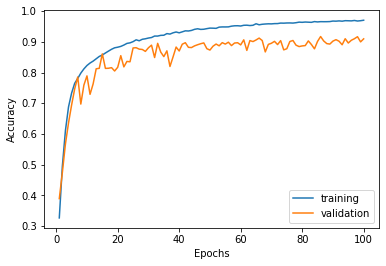

In [29]:
plt.plot(range(1,101), history["acc"], label = "training")
plt.plot(range(1,101), history["val_acc"], label = "validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## Transformer

- seq2seqとは
系列を入力にして、系列を出力する。  
Encoder-Decoderモデルとも呼ばれる。  
- 言語処理とRNN  
文章は時系列情報が重要になるのでRNNに適する。適切に構築したモデルを用いれば、次にくる単語として自然なものを予想することができる。  
次の単語が予想できるのであれば、最初の単語から文章を作っていくこともできる。  
これがEncoder-Decoderモデル。  


以下Seq2Seqの例を見る。

In [1]:
!pip install pip

In [2]:
from os import path

!pip install pytorch
import torch

  ERROR: Failed building wheel for pytorch
  Running setup.py clean for pytorch
Failed to build pytorch
    Running setup.py install for pytorch ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-mrudwsb_/pytorch/setup.py'"'"'; __file__='"'"'/tmp/pip-install-mrudwsb_/pytorch/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /tmp/pip-record-zwzs5kp0/install-record.txt --single-version-externally-managed --compile Check the logs for full command output.


In [3]:
! wget https://www.dropbox.com/s/9narw5x4uizmehh/utils.py
! mkdir images data

# data取得
! wget https://www.dropbox.com/s/o4kyc52a8we25wy/dev.en -P data/
! wget https://www.dropbox.com/s/kdgskm5hzg6znuc/dev.ja -P data/
! wget https://www.dropbox.com/s/gyyx4gohv9v65uh/test.en -P data/
! wget https://www.dropbox.com/s/hotxwbgoe2n013k/test.ja -P data/
! wget https://www.dropbox.com/s/5lsftkmb20ay9e1/train.en -P data/
! wget https://www.dropbox.com/s/ak53qirssci6f1j/train.ja -P data/

--2021-07-18 15:04:47--  https://www.dropbox.com/s/9narw5x4uizmehh/utils.py
Resolving www.dropbox.com (www.dropbox.com)... 162.125.4.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.4.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/9narw5x4uizmehh/utils.py [following]
--2021-07-18 15:04:47--  https://www.dropbox.com/s/raw/9narw5x4uizmehh/utils.py
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucbb722dfa955f3495f0987ce40f.dl.dropboxusercontent.com/cd/0/inline/BSjJ2_r8IhLeaLdGc3e7rz4pSNx4GPVg7AOLVdclLAVYIpBU7lETsQuiHShhyc1qvDLbgP9HAF5uBw1Ef-jReSydygvvCava4j_lw74fgn8u_Tq06Oe6II4QyVgXh9vKon-2FKIa3majbCxEnbBaZkX4/file# [following]
--2021-07-18 15:04:48--  https://ucbb722dfa955f3495f0987ce40f.dl.dropboxusercontent.com/cd/0/inline/BSjJ2_r8IhLeaLdGc3e7rz4pSNx4GPVg7AOLVdclLAVYIpBU7lETsQuiHShhyc1qvDLbgP9HAF5uBw1Ef-jReSydygvvCava4j_lw7

In [4]:
! head -10 data/train.en

i can 't tell who will arrive first .
many animals have been destroyed by men .
i 'm in the tennis club .
emi looks happy .
please bear this fact in mind .
she takes care of my children .
we want to be international .
you ought not to break your promise .
when you cross the street , watch out for cars .
i have nothing to live for .


In [5]:
import random
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from nltk import bleu_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils.rnn import pad_packed_sequence, pack_padded_sequence
from utils import Vocab

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(1)
random_state = 42

In [6]:
def load_data(file_path):
    data = []
    for line in open(file_path, encoding='utf-8'):
        words = line.strip().split()  
        data.append(words)
    return data

In [7]:
train_X = load_data('./data/train.en')
train_Y = load_data('./data/train.ja')

train_X, valid_X, train_Y, valid_Y = train_test_split(train_X, train_Y, test_size=0.2, random_state=random_state)

In [8]:
PAD_TOKEN = "<PAD>"
BOS_TOKEN = "<S>"
EOS_TOKEN = "</S>"
UNK_TOKEN = "<UNK>"
PAD = 0
BOS = 1
EOS = 2
UNK = 3

MIN_COUNT = 2

word2id = {
    PAD_TOKEN: PAD,
    BOS_TOKEN: BOS,
    EOS_TOKEN: EOS,
    UNK_TOKEN: UNK,
}

vocab_X = Vocab(word2id=word2id)
vocab_Y = Vocab(word2id=word2id)
vocab_X.build_vocab(train_X, min_count=MIN_COUNT)
vocab_Y.build_vocab(train_Y, min_count=MIN_COUNT)

vocab_size_X = len(vocab_X.id2word)
vocab_size_Y = len(vocab_Y.id2word)

In [9]:
def sentence_to_ids(vocab, sentence):
    ids = [vocab.word2id.get(word, UNK) for word in sentence]
    ids += [EOS]  
    return ids

In [10]:
train_X = [sentence_to_ids(vocab_X, sentence) for sentence in train_X]
train_Y = [sentence_to_ids(vocab_Y, sentence) for sentence in train_Y]
valid_X = [sentence_to_ids(vocab_X, sentence) for sentence in valid_X]
valid_Y = [sentence_to_ids(vocab_Y, sentence) for sentence in valid_Y]

In [11]:
def pad_seq(seq, max_length):
    res = seq + [PAD for i in range(max_length - len(seq))]
    return res

In [12]:
class DataLoader(object):

    def __init__(self, X, Y, batch_size, shuffle=False):
        self.data = list(zip(X, Y))
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.start_index = 0
        
        self.reset()
    
    def reset(self):
        if self.shuffle: 
            self.data = shuffle(self.data, random_state=random_state)
        self.start_index = 0  
    
    def __iter__(self):
        return self

    def __next__(self):
        if self.start_index >= len(self.data):
            self.reset()
            raise StopIteration()

        seqs_X, seqs_Y = zip(*self.data[self.start_index:self.start_index+self.batch_size])
        
        seq_pairs = sorted(zip(seqs_X, seqs_Y), key=lambda p: len(p[0]), reverse=True)
        seqs_X, seqs_Y = zip(*seq_pairs)
        
        lengths_X = [len(s) for s in seqs_X]
        lengths_Y = [len(s) for s in seqs_Y]
        max_length_X = max(lengths_X)
        max_length_Y = max(lengths_Y)
        padded_X = [pad_seq(s, max_length_X) for s in seqs_X]
        padded_Y = [pad_seq(s, max_length_Y) for s in seqs_Y]
        
        batch_X = torch.tensor(padded_X, dtype=torch.long, device=device).transpose(0, 1)
        batch_Y = torch.tensor(padded_Y, dtype=torch.long, device=device).transpose(0, 1)

        self.start_index += self.batch_size
        return batch_X, batch_Y, lengths_X

In [13]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size, padding_idx=PAD)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, seqs, input_lengths, hidden=None):
        emb = self.embedding(seqs)
        packed = pack_padded_sequence(emb, input_lengths)
        output, hidden = self.gru(packed, hidden)
        output, _ = pad_packed_sequence(output)
        return output, hidden

In [14]:
class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.embedding = nn.Embedding(output_size, hidden_size, padding_idx=PAD)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, seqs, hidden):
        emb = self.embedding(seqs)
        output, hidden = self.gru(emb, hidden)
        output = self.out(output)
        return output, hidden

In [15]:
class EncoderDecoder(nn.Module):
    def __init__(self, input_size, output_size, hidden_size):
        super(EncoderDecoder, self).__init__()
        self.encoder = Encoder(input_size, hidden_size)
        self.decoder = Decoder(hidden_size, output_size)

    def forward(self, batch_X, lengths_X, max_length, batch_Y=None, use_teacher_forcing=False):
        _, encoder_hidden = self.encoder(batch_X, lengths_X)
        
        _batch_size = batch_X.size(1)

        decoder_input = torch.tensor([BOS] * _batch_size, dtype=torch.long, device=device) 
        decoder_input = decoder_input.unsqueeze(0)  
        decoder_hidden = encoder_hidden  

        decoder_outputs = torch.zeros(max_length, _batch_size, self.decoder.output_size, device=device) 

        for t in range(max_length):
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
            decoder_outputs[t] = decoder_output
            if use_teacher_forcing and batch_Y is not None:  
                decoder_input = batch_Y[t].unsqueeze(0)
            else:  
                decoder_input = decoder_output.max(-1)[1]
                
        return decoder_outputs

In [16]:
mce = nn.CrossEntropyLoss(size_average=False, ignore_index=PAD) 
def masked_cross_entropy(logits, target):
    logits_flat = logits.view(-1, logits.size(-1)) 
    target_flat = target.view(-1) 
    return mce(logits_flat, target_flat)

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [17]:
num_epochs = 10
batch_size = 64
lr = 1e-3 
teacher_forcing_rate = 0.2  
ckpt_path = 'model.pth'  

model_args = {
    'input_size': vocab_size_X,
    'output_size': vocab_size_Y,
    'hidden_size': 256,
}

train_dataloader = DataLoader(train_X, train_Y, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_X, valid_Y, batch_size=batch_size, shuffle=False)

model = EncoderDecoder(**model_args).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

In [18]:
def compute_loss(batch_X, batch_Y, lengths_X, model, optimizer=None, is_train=True):
    model.train(is_train)  
     
    use_teacher_forcing = is_train and (random.random() < teacher_forcing_rate)
    max_length = batch_Y.size(0)

    pred_Y = model(batch_X, lengths_X, max_length, batch_Y, use_teacher_forcing)
    
    loss = masked_cross_entropy(pred_Y.contiguous(), batch_Y.contiguous())
    
    if is_train:  
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    batch_Y = batch_Y.transpose(0, 1).contiguous().data.cpu().tolist()
    pred = pred_Y.max(dim=-1)[1].data.cpu().numpy().T.tolist()

    return loss.item(), batch_Y, pred

In [19]:
def calc_bleu(refs, hyps):
    refs = [[ref[:ref.index(EOS)]] for ref in refs] # EOSは評価しないで良いので切り捨てる, refsのほうは複数なのでlistが一個多くかかっている
    hyps = [hyp[:hyp.index(EOS)] if EOS in hyp else hyp for hyp in hyps]
    return 100 * bleu_score.corpus_bleu(refs, hyps)

In [20]:
# 訓練
best_valid_bleu = 0.

for epoch in range(1, num_epochs+1):
    train_loss = 0.
    train_refs = []
    train_hyps = []
    valid_loss = 0.
    valid_refs = []
    valid_hyps = []

    for batch in train_dataloader:
        batch_X, batch_Y, lengths_X = batch
        loss, gold, pred = compute_loss(
            batch_X, batch_Y, lengths_X, model, optimizer, 
            is_train=True
            )
        train_loss += loss
        train_refs += gold
        train_hyps += pred

    for batch in valid_dataloader:
        batch_X, batch_Y, lengths_X = batch
        loss, gold, pred = compute_loss(
            batch_X, batch_Y, lengths_X, model, 
            is_train=False
            )
        valid_loss += loss
        valid_refs += gold
        valid_hyps += pred

    train_loss = np.sum(train_loss) / len(train_dataloader.data)
    valid_loss = np.sum(valid_loss) / len(valid_dataloader.data)

    train_bleu = calc_bleu(train_refs, train_hyps)
    valid_bleu = calc_bleu(valid_refs, valid_hyps)

    if valid_bleu > best_valid_bleu:
        ckpt = model.state_dict()
        torch.save(ckpt, ckpt_path)
        best_valid_bleu = valid_bleu

    print('Epoch {}: train_loss: {:5.2f}  train_bleu: {:2.2f}  valid_loss: {:5.2f}  valid_bleu: {:2.2f}'.format(
            epoch, train_loss, train_bleu, valid_loss, valid_bleu))
        
    print('-'*80)

Epoch 1: train_loss: 52.47  train_bleu: 3.18  valid_loss: 48.94  valid_bleu: 3.99
--------------------------------------------------------------------------------
Epoch 2: train_loss: 45.16  train_bleu: 7.07  valid_loss: 45.06  valid_bleu: 8.05
--------------------------------------------------------------------------------
Epoch 3: train_loss: 40.60  train_bleu: 10.89  valid_loss: 42.28  valid_bleu: 8.97
--------------------------------------------------------------------------------
Epoch 4: train_loss: 37.52  train_bleu: 13.96  valid_loss: 41.20  valid_bleu: 13.49
--------------------------------------------------------------------------------
Epoch 5: train_loss: 35.18  train_bleu: 16.33  valid_loss: 41.01  valid_bleu: 14.65
--------------------------------------------------------------------------------
Epoch 6: train_loss: 33.24  train_bleu: 18.72  valid_loss: 39.80  valid_bleu: 14.79
--------------------------------------------------------------------------------
Epoch 7: train_

In [21]:
ckpt = torch.load(ckpt_path)
model.load_state_dict(ckpt)
model.eval()

EncoderDecoder(
  (encoder): Encoder(
    (embedding): Embedding(3725, 256, padding_idx=0)
    (gru): GRU(256, 256)
  )
  (decoder): Decoder(
    (embedding): Embedding(4405, 256, padding_idx=0)
    (gru): GRU(256, 256)
    (out): Linear(in_features=256, out_features=4405, bias=True)
  )
)

In [22]:
def ids_to_sentence(vocab, ids):
    return [vocab.id2word[_id] for _id in ids]

def trim_eos(ids):
    if EOS in ids:
        return ids[:ids.index(EOS)]
    else:
        return ids

In [23]:
test_X = load_data('./data/dev.en')
test_Y = load_data('./data/dev.ja')

test_X = [sentence_to_ids(vocab_X, sentence) for sentence in test_X]
test_Y = [sentence_to_ids(vocab_Y, sentence) for sentence in test_Y]

test_dataloader = DataLoader(test_X, test_Y, batch_size=1, shuffle=False)

In [28]:
batch_X, batch_Y, lengths_X = next(test_dataloader)
sentence_X = ' '.join(ids_to_sentence(vocab_X, batch_X.data.cpu().numpy()[:-1, 0]))
sentence_Y = ' '.join(ids_to_sentence(vocab_Y, batch_Y.data.cpu().numpy()[:-1, 0]))
print('src: {}'.format(sentence_X))
print('tgt: {}'.format(sentence_Y))

output = model(batch_X, lengths_X, max_length=20)
output = output.max(dim=-1)[1].view(-1).data.cpu().tolist()
output_sentence = ' '.join(ids_to_sentence(vocab_Y, trim_eos(output)))
output_sentence_without_trim = ' '.join(ids_to_sentence(vocab_Y, output))
print('out: {}'.format(output_sentence))
print('without trim: {}'.format(output_sentence_without_trim))

src: no . i 'm sorry , i 've got to go back early .
tgt: ごめん なさ い 。 早 く 帰 ら な く ちゃ 。
out: 早 く な く く く く く な り ま せ ん 。
without trim: 早 く な く く く く く な り ま せ ん 。 </S> </S> </S> </S> </S> </S>


In [25]:
test_dataloader = DataLoader(test_X, test_Y, batch_size=1, shuffle=False)
refs_list = []
hyp_list = []

for batch in test_dataloader:
    batch_X, batch_Y, lengths_X = batch
    pred_Y = model(batch_X, lengths_X, max_length=20)
    pred = pred_Y.max(dim=-1)[1].view(-1).data.cpu().tolist()
    refs = batch_Y.view(-1).data.cpu().tolist()
    refs_list.append(refs)
    hyp_list.append(pred)
bleu = calc_bleu(refs_list, hyp_list)
print(bleu)

16.72871429962597


- NN機械翻訳の弱点  
最初に文章を一つのベクトルに集約している。その結果長い文章（情報量が多い）を用いると、ベクトルの表現力が足りなくなり、制度が悪くなる。  
- Attention(辞書オブジェクト)  
翻訳元で重要な単語に重みを置く。⇒ベクトルに集約するときに情報を失いにくい  
query,Key,Valueの三要素からなる。  
- Transformer  
Attensionをつかう。RNNを使わない。最初に位置情報を付与して計算を行う（RNNを使わないから)。  
- Self-Attention  
Attentionの一つ。度の単語が重要かを、自己完結で学習していく。  
- Scaled dot product attention  
全単語に関するAttentionをまとめて計算する。  
$$
    Attention(Q,K,V) = softmax \left( \frac{QK^T}{\sqrt{d_k}} \right) V
$$
- Multi-Head Attention  
Scaled dot product attentionを8個連結したもの。attentionの付け方を複数もたせて、アンサンブル学習ライクな効果を期待している。  
- Add&Norm  
Add:入出力の差分を学習させる（学習効率があがるテクニック）  
Norm:各層においてバイアスを除く活性化関数への入力を平均0、分散1に正則化(高速化テクニック）  



## 物体検知・セグメンテーション

- 物体認識とは？  
画像を入力に受けて、物体認識をする。「分類」「物体件い」「意味領域分割」「個体領域分割」を行う。画像に対して、どこに何が移っているのか、を出力として与える。  
- データセット  
代表的なデータセットが存在し、それぞれに特徴がある。  
VOC12 : 物質ここにラベルが割り当てられている。クラス数20、データサイズ11540。Box/画像:2.4。  
ILSVRC17 : クラス数200、データ数476668、ImageNetのサブセット。Box/画像:1.1。  
MS COCO18 : 物質ここにラベルが割り当てられている。クラス数80,データ数123297。Box/画像:7.3。  
OICOD18 : 物質ここにラベルが割り当てられている。クラス数500、データ数1743042、Open ImagesV4のサブセット。Box/画像:7.0。  
- 評価指標  
まず通常のクラス分類問題の評価指標として、accuracy,precision,recall,(F)などがある。  
物体検出では、thresouldの変化に応じて、設定されるラベルの総数が変化する。  
- IoU: Intersection over Union : Jaccard係数  
$IoU = \frac{TP}{TP+FP+FN}$となる。画素単位で計算する。物体検出では、confidenceのほかにIoUも閾値として設定されることになる。  
複数の画像を考える場合にも、TPFPの判断をして、Precision、Recallの計算をする。クラス単位でPrecisionとRecallの計算を行う。  
IoUを固定し、confidenceの閾値を変化させることでPR曲線を描くことができる（一般のクラス分類問題と同様）。PR曲線を描くことができれば、AP(PR曲線の下側面積）を求めることができる。クラスラベルごとに求めたAPの算術平均を求め、それをmAPと呼ぶ。（当たり前だが、なんでもかんでも”人”のラベルをつけるようなモデルはだめ）  
mAPはIoCの閾値の関数になるので、0.5から0.05刻みで平均を取ったmAPcocoのような指標もある。  
- 物体検知の大枠  
AlexNet以降にSIFT,DCNNへ。
- 代表的なネットワーク  
VGGNew, GoogLeNet(Inception-v1), ResNet, Inception-ResNet(Inception-v4), DenseNet,MobileNet,AmoebaNet。  
- 代表的な、物体検知のフレームワーク  
 - 2段階検出器:候補領域の検出とクラス推定を別々に行う。制度は良いが、遅い。   
 RCNN, SPPNet, Fast RCNN, Faster RCNN, RFCN, FPN, Mask RCNN  
 - 1段階検出器:候補領域の検出とクラス推定を同時に行う。制度は低いが、速い。  
 DetectorNet, YOLO, SSD, YOLO9000, RetinaNet, CornerNet  
- SSD  
以下の手順で出力をする。  
 1. Default BOXを用意  
 2. Default BOXを変形し、confidenceを出力する。  
SSDではVGG16を元にしたネットワークを用いる。VGG16はConvolution,Max Pooling, 全結合を組み合わせてネットワークを表現する。SSDでは、一部層構造を変更したうえで、解像度の異なるConv層から特徴マップを作成する。8000以上のDefault Boxが用意される。多数のBOXが用意されたために、1つの物体に複数のBOXが対応してしまうこともある。そのため、confidenceが最も近いものを選ぶようにする。  

- Semantic Segmentationの肝  
物体検知では、各ピクセルごとにしゅつりょくを得るが、コンボリューション層とプーリング層では、画像のピクセルが落ちてしまう。これをどのように元のピクセル数に戻すのか（upsampling）が肝になる。  
- なぜPoolingが必要か？  
演算量をそこまで増やさずに、受容野を広げるため。  
- Deconvolution/Transposed convolution    
特徴マップのpixelに間隔をあけ、周囲に余白を作る。⇒畳み込み演算を行う。  
低レイヤーのPooling層の出力を足し算することで詳細情報を補完する。  
